# **Install & Import Libraries**
Install required libraries

Import essential packages for QA development

In [ ]:
# ===============================
# Core Python and ML Libraries
# ===============================

import pandas as pd  # For data manipulation and analysis using DataFrames
import numpy as np   # For efficient numerical operations on arrays
import torch         # Core library for building and training deep learning models

# For batching and preparing data loaders in PyTorch
from torch.utils.data import Dataset, DataLoader

# ======================================
# HuggingFace Transformers and Tokenizer
# ======================================

from transformers import BertTokenizerFast, BertForQuestionAnswering
# BertTokenizerFast: Efficient tokenizer for BERT (returns offsets, fast tokenization)
# BertForQuestionAnswering: Pretrained BERT model fine-tuned for question answering tasks

# ==================================================
# HuggingFace Dataset Utility (Optional, Not Always Used)
# ==================================================

# ======================
# Utility Libraries
# ======================

from sklearn.model_selection import train_test_split
# train_test_split: Split dataset into training and validation sets

from tqdm import tqdm
# tqdm: Display progress bars in loops for better tracking of processing steps

# ===========================
# Device Configuration
# ===========================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# This selects GPU if available, otherwise defaults to CPU

print(f"Using device: {device}")
# Confirms to the user whether the code is running on GPU or CPU

Using device: cuda


Mount Google drive to load the the trained Model to the Drive

In [ ]:
# ================================
#  MOUNT GOOGLE DRIVE IN COLAB
# ================================

# Import Colab Drive module to enable access to the Google Drive
from google.colab import drive

# Mount the Google Drive to '/content/drive'
# User'll be prompted to authorize access with your Google account
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

# **Load and Preview SQuAD 2.0 Dataset in Google Colab**
This block installs the HuggingFace datasets library, loads the SQuAD v2 dataset (train & validation sets), converts them to pandas DataFrames for easier inspection, and prints basic stats.


In [ ]:
# ================================
# LOAD AND PREVIEW SQuAD 2.0 DATASET
# ================================

# Step 1: Install the HuggingFace datasets library (if not already installed)
# Required to load popular NLP datasets like SQuAD, IMDB, etc.
!pip install -q datasets

# Step 2: Import the load_dataset function from the datasets module
from datasets import load_dataset

# Step 3: Load the official SQuAD 2.0 dataset
# Returns a DatasetDict with 'train' and 'validation' splits
squad_dataset = load_dataset("squad_v2")

# Step 4: Convert the HuggingFace dataset to pandas DataFrame
# This makes it easier to inspect and manipulate the data using pandas
df_train = pd.DataFrame(squad_dataset['train'])
df_valid = pd.DataFrame(squad_dataset['validation'])

# Step 5: Print basic information about the dataset
print("Dataset loaded successfully!")
print(f"Train samples: {len(df_train)}, Validation samples: {len(df_valid)}")

# Step 6: Display the first 5 records from the training set
display(df_train.head(5))

# Step 7: Print summary information about the columns in the training DataFrame
df_train.info()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 24.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 130319, Validation samples: 11873


,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        130319 non-null  object
 1   title     130319 non-null  object
 2   context   130319 non-null  object
 3   question  130319 non-null  object
 4   answers   130319 non-null  object
dtypes: object(5)
memory usage: 5.0+ MB


# **Preprocess SQuAD 2.0 Dataset – Clean Answer Fields and Mark Unanswerables 2.0**
This section defines a preprocessing function that extracts the clean answer text, calculates start/end positions, and identifies whether a question is unanswerable based on the SQuAD v2.0 format. It then applies this function to both the training and validation sets.

In [ ]:
# ==========================================
# STEP: CLEAN AND TRANSFORM SQuAD FIELDS
# ==========================================

# Step 1: Define a function to extract clean answer fields and mark unanswerable questions
def preprocess_squad_df(df):
    clean_answers = []       # Store cleaned answer text
    start_positions = []     # Store character-level start positions
    end_positions = []       # Store character-level end positions
    impossible_flags = []    # Store boolean flags for 'is_impossible'

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        answers = row['answers']

        # If answer exists, extract the first text and start position
        if answers['text']:
            clean_answer = answers['text'][0]
            start = answers['answer_start'][0]
            end = start + len(clean_answer)
            is_impossible = False
        else:
            # For unanswerable questions, mark fields accordingly
            clean_answer = "No answer"
            start = 0
            end = 0
            is_impossible = True

        # Append results to the respective lists
        clean_answers.append(clean_answer)
        start_positions.append(start)
        end_positions.append(end)
        impossible_flags.append(is_impossible)

    # Add new columns to the original DataFrame
    df['clean_answer'] = clean_answers
    df['answer_start'] = start_positions
    df['answer_end'] = end_positions
    df['is_impossible'] = impossible_flags

    return df


# Step 2: Apply preprocessing function to both training and validation datasets
df_train = preprocess_squad_df(df_train)
df_valid = preprocess_squad_df(df_valid)

# Step 3: Inspect a subset of the new structure to verify preprocessing
# Shows cleaned answers, their span positions, and if the question is unanswerable
df_train[['context', 'question', 'clean_answer', 'answer_start', 'answer_end', 'is_impossible']].head(10)


,context,question,clean_answer,answer_start,answer_end,is_impossible
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286,False
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226,False
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530,False
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180,False
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286,False
5,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,Destiny's Child,320,335,False
6,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,Dangerously in Love,505,524,False
7,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,Mathew Knowles,360,374,False
8,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,late 1990s,276,286,False
9,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,lead singer,290,301,False


# **Visual Exploration of SQuAD 2.0 Training Set**


This section visualizes answerability, tokenized input length, and content structure of the SQuAD v2.0 training dataset using seaborn and matplotlib.

In [ ]:
# ============================================
# IMPORT REQUIRED VISUALIZATION AND TOKENIZER TOOLS
# ============================================

import matplotlib.pyplot as plt  # Plotting library for figures and charts
import seaborn as sns            # High-level interface for attractive statistical plots
from transformers import BertTokenizerFast  # Fast tokenizer from HuggingFace

# Load pre-trained BERT tokenizer (fast version ensures alignment with tokens)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Distribution of Answerable vs. Unanswerable Questions

<ipython-input-9-77e446731426>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


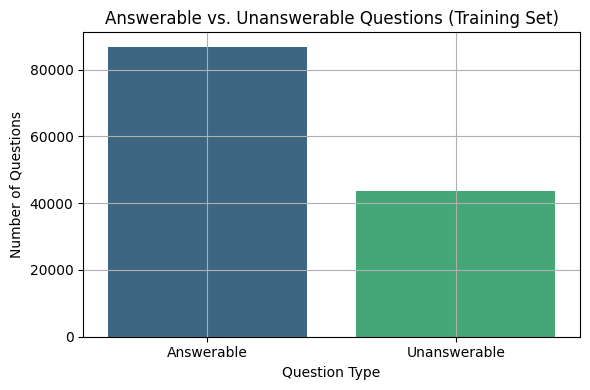

 Answerable distribution:
answerable
True     86821
False    43498
Name: count, dtype: int64


In [ ]:
# Create a new column where True = answerable, False = unanswerable
df_train['answerable'] = ~df_train['is_impossible']
answerable_counts = df_train['answerable'].value_counts()

# Plot a bar chart comparing answerable and unanswerable question counts
plt.figure(figsize=(6, 4))
sns.barplot(
    x=answerable_counts.index.map({True: 'Answerable', False: 'Unanswerable'}),
    y=answerable_counts.values,
    palette="viridis"
)
plt.title("Answerable vs. Unanswerable Questions (Training Set)")
plt.ylabel("Number of Questions")
plt.xlabel("Question Type")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display count values in text
print(" Answerable distribution:")
print(answerable_counts)


Tokenized Input Length Distribution (Question + Context)

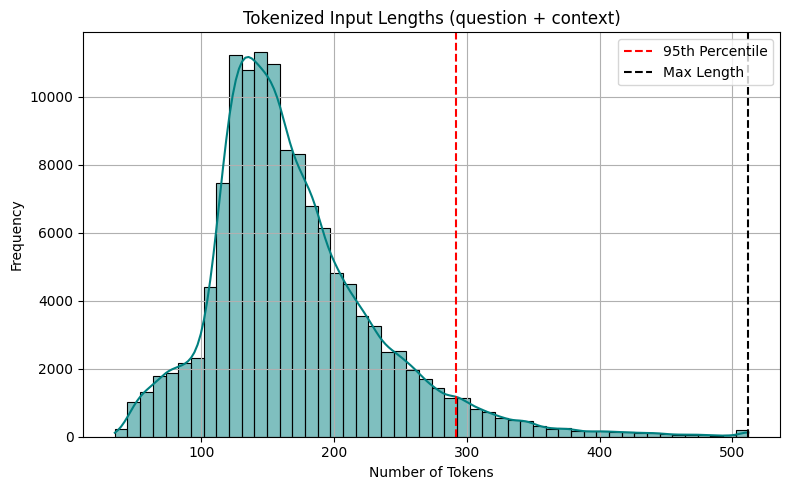

Max input length: 512
 95th percentile length: 292


In [ ]:
# Define a function to compute tokenized input length for each question-context pair
def compute_input_length(row):
    encoded = tokenizer(
        row['question'], row['context'],
        truncation=True, max_length=512, padding=False,
        return_tensors=None
    )
    return len(encoded['input_ids'])

# Apply the function to the training set
df_train['input_length'] = df_train.apply(compute_input_length, axis=1)

# Plot the distribution of input lengths
plt.figure(figsize=(8, 5))
sns.histplot(df_train['input_length'], bins=50, kde=True, color='teal')
plt.axvline(df_train['input_length'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
plt.axvline(df_train['input_length'].max(), color='black', linestyle='--', label='Max Length')
plt.title("Tokenized Input Lengths (question + context)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Max input length:", df_train['input_length'].max())
print(" 95th percentile length:", int(df_train['input_length'].quantile(0.95)))


Additional Visual Analysis


Question Length in Words

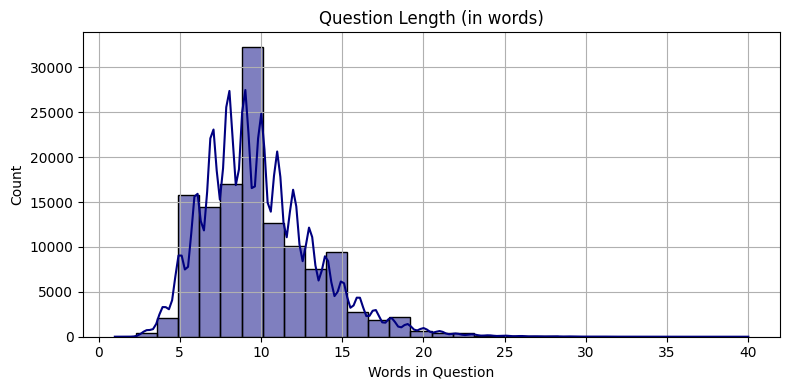

In [ ]:
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df_train['question_length'], bins=30, kde=True, color='navy')
plt.title("Question Length (in words)")
plt.xlabel("Words in Question")
plt.grid(True)
plt.tight_layout()
plt.show()


Context Length in Words

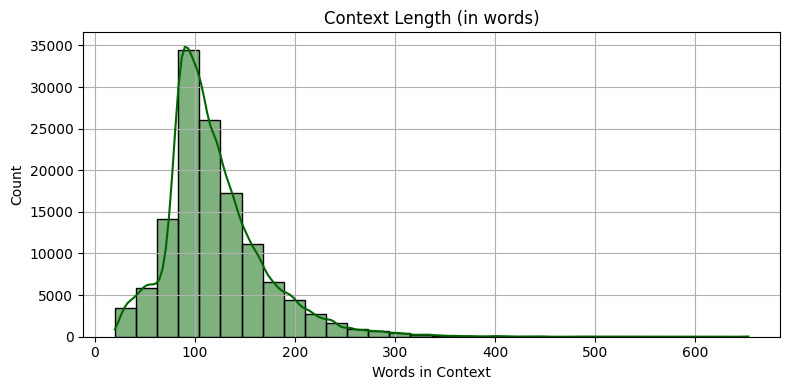

In [ ]:
df_train['context_length'] = df_train['context'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df_train['context_length'], bins=30, kde=True, color='darkgreen')
plt.title("Context Length (in words)")
plt.xlabel("Words in Context")
plt.grid(True)
plt.tight_layout()
plt.show()


Top 20 Article Titles by Question Count

<ipython-input-13-da690b960a0f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_counts.index, x=title_counts.values, palette="crest")


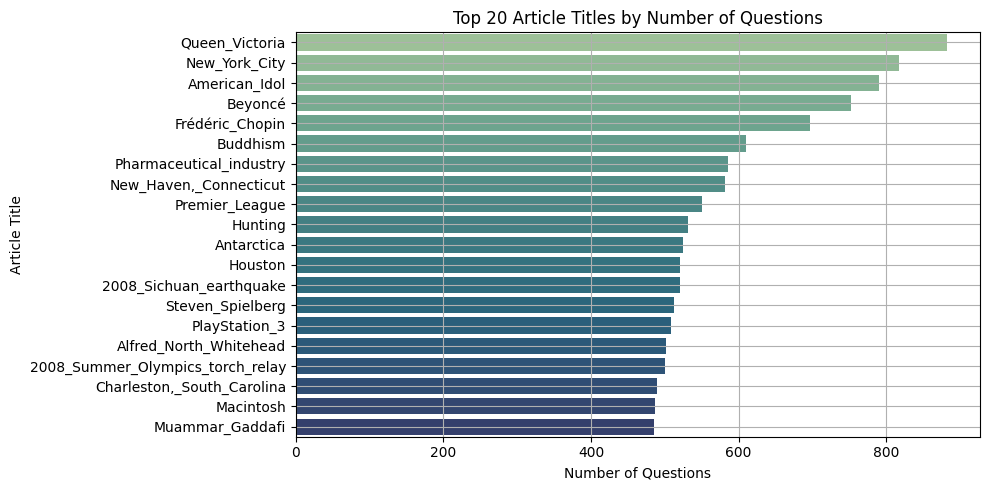

In [ ]:
title_counts = df_train['title'].value_counts().head(20)

plt.figure(figsize=(10, 5))
sns.barplot(y=title_counts.index, x=title_counts.values, palette="crest")
plt.title("Top 20 Article Titles by Number of Questions")
plt.xlabel("Number of Questions")
plt.ylabel("Article Title")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Split df_train into two sets**
df_train_final → 80% of original training (used for training)

df_val_final → 20% of original training (used for validation during training)

df_valid → untouched original validation set from SQuAD (used only for final evaluation)




In [ ]:
#custom 80/20 split on the original SQuAD training set, creating a new training and validation subset from it.

from sklearn.model_selection import train_test_split

#  80/20 Split of original training set
df_train_final, df_val_final = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train["is_impossible"]
)

print(f"Training samples: {len(df_train_final)}")
print(f" Validation samples: {len(df_val_final)}")
print(f"External Test samples (SQuAD val): {len(df_valid)}")


Training samples: 104255
 Validation samples: 26064
External Test samples (SQuAD val): 11873


# **Tokenize and Align QA Data**
Tokenize each (question, context) pair using BertTokenizerFast

Convert answer_start (character index) to token-level indices

Handle special cases (unanswerable questions with "No answer")

In [ ]:
#  a solid tokenization pipeline for extractive QA, with handling for unanswerable questions and max-length truncation.

from transformers import BertTokenizerFast

# Load fast tokenizer (already done before, but repeating just in case)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Function to tokenize and align start/end positions
def tokenize_and_align(df, tokenizer, max_length=384):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Tokenizing"):
        question = row['question']
        context = row['context']
        answer_text = row['clean_answer']
        answer_start_char = row['answer_start']
        answer_end_char = row['answer_end']
        is_impossible = row['is_impossible']

        # Tokenize with offset mapping
        encoding = tokenizer(
            question,
            context,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_offsets_mapping=True,
            return_tensors="pt"
        )

        offsets = encoding['offset_mapping'][0]
        input_id = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]

        # Default positions for unanswerable questions
        start_pos = 0
        end_pos = 0

        if not is_impossible:
            # Find the start/end token indices within the context
            for i, (start, end) in enumerate(offsets):
                if start <= answer_start_char < end:
                    start_pos = i
                if start < answer_end_char <= end:
                    end_pos = i
                    break
            # If no match found, fallback to 0
            if start_pos == 0 and end_pos == 0:
                start_pos = 0
                end_pos = 0

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        start_positions.append(start_pos)
        end_positions.append(end_pos)

    return {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(attention_masks),
        "start_positions": torch.tensor(start_positions),
        "end_positions": torch.tensor(end_positions)
    }

# Tokenize all three: train (80%), val (20%), and external SQuAD validation
train_encodings = tokenize_and_align(df_train_final, tokenizer)
val_encodings = tokenize_and_align(df_val_final, tokenizer)
valid_encodings = tokenize_and_align(df_valid, tokenizer)

print(" Tokenization complete for all sets.")
# % of rows exeeding max length =384 tokens

# Calculate input_length for df_train_final and df_val_final
def compute_input_length(row):
    encoded = tokenizer(
        row['question'], row['context'],
        truncation=True, max_length=512, padding=False,
        return_tensors=None
    )
    return len(encoded['input_ids'])

df_train_final['input_length'] = df_train_final.apply(compute_input_length, axis=1)
df_val_final['input_length'] = df_val_final.apply(compute_input_length, axis=1)
print("% of number rows exeding the chosen no max tokens in df_train_final: ",(df_train_final['input_length'] > 384).mean())
print("% of number rows exeding the chosen no max tokens in df_train_val: ",(df_val_final['input_length'] > 384).mean())


Tokenizing: 100%|██████████| 11873/11873 [00:32<00:00, 360.29it/s]


 Tokenization complete for all sets.
% of number rows exeding the chosen no max tokens in df_train_final:  0.010426358448036065
% of number rows exeding the chosen no max tokens in df_train_val:  0.010972989564149785


# **Create QADataset and DataLoader**
Wrap train_encodings and valid_encodings in a PyTorch-compatible dataset class

Enable batch loading using DataLoader

Ready the data for use in training and evaluation loops

In [ ]:
#wrap up the preprocessing pipeline and prepare everything for training the BERT model on QA data using PyTorch

from torch.utils.data import Dataset, DataLoader

# Step 1: Custom Dataset class
class QADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'start_positions': self.encodings['start_positions'][idx],
            'end_positions': self.encodings['end_positions'][idx]
        }

# Step 2: Wrap Encodings into DataLoaders
train_dataset = QADataset(train_encodings)
val_dataset   = QADataset(val_encodings)
valid_dataset = QADataset(valid_encodings)

#  Step 3: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

#  Step 4: Sanity Check
print(" DataLoaders created:")
print(f" train_loader → {len(train_loader)} batches")
print(f" val_loader   → {len(val_loader)} batches")
print(f" valid_loader → {len(valid_loader)} batches")

#  Test: Check one sample
sample = train_dataset[0]
print("Sample input_ids shape:", sample['input_ids'].shape)
print("Start token index:", sample['start_positions'])
print("End token index:", sample['end_positions'])


 DataLoaders created:
 train_loader → 6516 batches
 val_loader   → 1629 batches
 valid_loader → 743 batches
Sample input_ids shape: torch.Size([384])
Start token index: tensor(8)
End token index: tensor(12)


# **BERT Model Setup and Optimizer Configuration**
Load a pretrained BERT model for question answering

Move the model to the correct device (GPU/CPU)

Define the loss function and optimizer

In [ ]:
# this block sets up the model and optimizer, making it fully ready to train.

from transformers import BertForQuestionAnswering
from torch.optim import AdamW  #  Fixed import

#  Load BERT QA model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Move model to device (GPU if available)
model.to(device)
print(f" Model loaded and moved to: {device}")

#  Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#  Sanity check
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded and moved to: cuda
Number of trainable parameters: 108,893,186


# **Full Enhanced QA Model Trainer with Evaluation and Visualization**

This block builds a robust production-quality training pipeline for a fine-tuned QA model with advanced features like validation evaluation, early stopping, learning rate scheduler, mixed-precision training, sample predictions, and visual plots of loss and accuracy.


In [ ]:
# ============================================================
# FULL ENHANCED TRAINING LOOP FOR QUESTION ANSWERING MODEL
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# ============================================================
# TRAINING FUNCTION WITH ENHANCEMENTS
# ============================================================

def train_with_enhancements(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    total_steps,
    eval_every=1000,
    use_scheduler=True,
    use_early_stopping=True,
    early_stopping_patience=5,
    show_predictions_every=500,
    use_mixed_precision=True
):
    """
    Fine-tunes the QA model with smart features like validation checks, early stopping,
    learning rate scheduling, mixed-precision training, and live sample predictions.
    """
    model.to(device)
    model.train()

    # Initialize mixed precision scaler
    scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)

    # Initialize learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,  # 10% warmup
        num_training_steps=total_steps
    ) if use_scheduler else None

    step = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    progress = tqdm(total=total_steps, desc="Training")

    while step < total_steps:
        for batch in train_loader:
            model.train()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=use_mixed_precision):
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions
                )
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            train_losses.append(loss.item())
            progress.set_postfix({"Loss": loss.item(), "Step": step})
            progress.update(1)
            step += 1

            # Perform validation at regular intervals
            if step % eval_every == 0 or step == total_steps:
                val_loss, val_acc = evaluate_on_validation(model, val_loader, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

                print(f"\n Step {step} — Val Loss: {val_loss:.4f} | EM Accuracy: {val_acc:.2f}%")

                # Save the best model based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), "best_model.pt")
                else:
                    epochs_no_improve += 1

                # Trigger early stopping if needed
                if use_early_stopping and epochs_no_improve >= early_stopping_patience:
                    print("Early stopping triggered.")
                    progress.close()
                    return train_losses, val_losses, val_accuracies

            # Display sample prediction occasionally
            if step % show_predictions_every == 0:
                try:
                    model.eval()
                    sample_input_ids = input_ids[0]
                    sample_context = tokenizer.decode(sample_input_ids, skip_special_tokens=True)

                    offsets = tokenizer(
                        sample_context,
                        return_offsets_mapping=True,
                        truncation=True,
                        max_length=384,
                        padding='max_length'
                    )['offset_mapping']

                    pred_start = torch.argmax(outputs.start_logits[0])
                    pred_end = torch.argmax(outputs.end_logits[0])

                    if pred_start < len(offsets) and pred_end < len(offsets):
                        start_char = offsets[pred_start][0]
                        end_char = offsets[pred_end][1]
                        pred_answer = sample_context[start_char:end_char].strip()
                    else:
                        pred_answer = "[Invalid span]"

                    print("\n[Sample Prediction]")
                    print(f"Predicted Answer: {pred_answer}")
                except:
                    pass

            if step >= total_steps:
                break

    progress.close()
    return train_losses, val_losses, val_accuracies

# ============================================================
# VALIDATION EVALUATION FUNCTION
# ============================================================

def evaluate_on_validation(model, val_loader, device):
    """
    Evaluates model on validation dataset, returning average loss and simple EM accuracy.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions
            )

            loss = outputs.loss
            total_loss += loss.item()

            start_preds = torch.argmax(outputs.start_logits, dim=1)
            end_preds = torch.argmax(outputs.end_logits, dim=1)
            correct += ((start_preds == start_positions) & (end_preds == end_positions)).sum().item()
            total += input_ids.size(0)

    avg_loss = total_loss / len(val_loader)
    acc = 100.0 * correct / total
    return avg_loss, acc

# ============================================================
# PLOTTING FUNCTION: TRAINING AND VALIDATION CURVES
# ============================================================

def plot_loss(train_losses, val_losses, val_accuracies):
    """
    Plots training loss curve, validation loss curve, and validation EM accuracy.
    """
    steps = list(range(1, len(val_losses) + 1))
    plt.figure(figsize=(12, 5))

    # Subplot 1: Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(np.linspace(0, len(train_losses), len(val_losses)), val_losses, label="Val Loss", color='red')
    plt.title("Loss Curve")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Subplot 2: Validation accuracy curve


## Train QA Model with Advanced Training Features and Save for Deployment

This block fine-tunes a QA model using features like learning rate scheduler, early stopping, mixed-precision training, evaluation checkpoints, and sample span predictions. After training, the best model and tokenizer are saved for future inference or deployment.

In [ ]:
# ============================================================
# TRAIN QA MODEL WITH SCHEDULER, EARLY STOPPING, MIXED PRECISION
# SAVE MODEL AND TOKENIZER FOR INFERENCE
# ============================================================

from torch.optim import AdamW  # Import AdamW optimizer from torch
from transformers import BertForQuestionAnswering
import os

# -----------------------
# Step 1: Prepare Model and Optimizer
# -----------------------

# Move model to the appropriate device (GPU/CPU)
model.to(device)

# Define optimizer (AdamW is commonly used for Transformer models)
optimizer = AdamW(model.parameters(), lr=2e-5)

# -----------------------
# Step 2: Define Training Parameters
# -----------------------

# Total number of steps to train
# Example: If roughly 500 steps per epoch, 5 epochs → 2500 steps. Here adjusted to 40,000 steps.
total_steps = 40000

# Frequency for validation and sample predictions
eval_every = 1000            # Validate every 1000 steps
show_predictions_every = 2000  # Print a sample prediction every 2000 steps

# -----------------------
# Step 3: Start Model Training
# -----------------------

train_losses, val_losses, val_accuracies = train_with_enhancements(
    model=model,
    train_loader=train_loader,      # Training data loader (prepared earlier)
    val_loader=val_loader,          # Validation data loader (prepared earlier)
    optimizer=optimizer,
    device=device,
    total_steps=total_steps,
    eval_every=eval_every,
    use_scheduler=True,             # Use linear scheduler with warmup
    use_early_stopping=True,         # Stop early if no improvement
    early_stopping_patience=8,       # Number of validations to wait before stopping
    show_predictions_every=show_predictions_every,
    use_mixed_precision=True         # Use mixed precision if using GPU
)

# -----------------------
# Step 4: Save Best Model and Tokenizer
# -----------------------
"""
# Define output directory for saved model and tokenizer
model_dir = "/content/qa_model_checkpoint"
os.makedirs(model_dir, exist_ok=True)

# Save model weights and config
model.save_pretrained(model_dir)

# Save tokenizer files (vocab, config, etc.)
tokenizer.save_pretrained(model_dir)

# Confirmation message
print(f"Model and tokenizer saved to: {model_dir}")


<ipython-input-12-35d5c344d07c>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)
Training:   0%|          | 0/40000 [00:00<?, ?it/s]<ipython-input-12-35d5c344d07c>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_mixed_precision):
Training:   2%|▎         | 1000/40000 [05:03<3:17:19,  3.29it/s, Loss=2.92, Step=999]


📊 Step 1000 — Val Loss: 2.5862 | EM Accuracy: 27.80%


Training:   5%|▌         | 2000/40000 [20:12<3:12:14,  3.29it/s, Loss=1.56, Step=1999]


📊 Step 2000 — Val Loss: 1.9236 | EM Accuracy: 33.64%

 [Sample Prediction]
Predicted: 


Training:   8%|▊         | 3000/40000 [35:17<3:07:38,  3.29it/s, Loss=1.61, Step=2999]


📊 Step 3000 — Val Loss: 1.6772 | EM Accuracy: 40.29%


Training:  10%|█         | 4000/40000 [50:22<3:00:31,  3.32it/s, Loss=1.29, Step=3999]


📊 Step 4000 — Val Loss: 1.5111 | EM Accuracy: 46.98%

 [Sample Prediction]
Predicted: 


Training:  12%|█▎        | 5000/40000 [1:05:25<2:56:42,  3.30it/s, Loss=1.7, Step=4999]


📊 Step 5000 — Val Loss: 1.4008 | EM Accuracy: 47.64%


Training:  15%|█▌        | 6000/40000 [1:20:30<2:51:45,  3.30it/s, Loss=1.26, Step=5999]


📊 Step 6000 — Val Loss: 1.3024 | EM Accuracy: 51.52%

 [Sample Prediction]
Predicted: time.


Training:  18%|█▊        | 7000/40000 [1:35:32<2:46:31,  3.30it/s, Loss=1.46, Step=6999]


📊 Step 7000 — Val Loss: 1.2644 | EM Accuracy: 54.40%


Training:  20%|██        | 8000/40000 [1:50:35<2:41:30,  3.30it/s, Loss=0.991, Step=7999]


📊 Step 8000 — Val Loss: 1.2949 | EM Accuracy: 52.55%

 [Sample Prediction]
Predicted: 914. 8 billion for


Training:  22%|██▎       | 9000/40000 [2:05:32<2:36:20,  3.30it/s, Loss=1.48, Step=8999]


📊 Step 9000 — Val Loss: 1.1759 | EM Accuracy: 56.31%


Training:  25%|██▌       | 10000/40000 [2:20:35<2:31:37,  3.30it/s, Loss=1.36, Step=9999]


📊 Step 10000 — Val Loss: 1.1935 | EM Accuracy: 55.14%

 [Sample Prediction]
Predicted: 


Training:  28%|██▊       | 11000/40000 [2:35:32<2:25:29,  3.32it/s, Loss=2.02, Step=10999]


📊 Step 11000 — Val Loss: 1.1337 | EM Accuracy: 57.65%


Training:  30%|███       | 12000/40000 [2:50:41<2:20:12,  3.33it/s, Loss=0.759, Step=11999]


📊 Step 12000 — Val Loss: 1.1472 | EM Accuracy: 56.75%

 [Sample Prediction]
Predicted: 


Training:  32%|███▎      | 13000/40000 [3:05:38<2:16:35,  3.29it/s, Loss=0.985, Step=12999]


📊 Step 13000 — Val Loss: 1.0836 | EM Accuracy: 58.26%


Training:  35%|███▌      | 14000/40000 [3:20:42<2:11:38,  3.29it/s, Loss=0.933, Step=13999]


📊 Step 14000 — Val Loss: 1.1659 | EM Accuracy: 58.92%

 [Sample Prediction]
Predicted: 


Training:  38%|███▊      | 15000/40000 [3:35:39<2:06:13,  3.30it/s, Loss=0.63, Step=14999]


📊 Step 15000 — Val Loss: 1.1580 | EM Accuracy: 59.16%


Training:  40%|████      | 16000/40000 [3:50:36<2:01:51,  3.28it/s, Loss=0.401, Step=15999]


📊 Step 16000 — Val Loss: 1.1191 | EM Accuracy: 58.89%

 [Sample Prediction]
Predicted: shan empire


Training:  42%|████▎     | 17000/40000 [4:05:33<1:56:08,  3.30it/s, Loss=1.03, Step=16999]


📊 Step 17000 — Val Loss: 1.1526 | EM Accuracy: 57.42%


Training:  45%|████▌     | 18000/40000 [4:20:30<1:51:13,  3.30it/s, Loss=0.353, Step=17999]


📊 Step 18000 — Val Loss: 1.1258 | EM Accuracy: 59.09%

 [Sample Prediction]
Predicted: 


Training:  48%|████▊     | 19000/40000 [4:35:27<1:46:15,  3.29it/s, Loss=1.05, Step=18999]


📊 Step 19000 — Val Loss: 1.1211 | EM Accuracy: 59.21%


Training:  50%|█████     | 20000/40000 [4:50:24<1:41:03,  3.30it/s, Loss=0.838, Step=2e+4]


📊 Step 20000 — Val Loss: 1.2108 | EM Accuracy: 60.08%

 [Sample Prediction]
Predicted: were


Training:  52%|█████▎    | 21000/40000 [5:15:14<4:45:13,  1.11it/s, Loss=0.425, Step=20999]


📊 Step 21000 — Val Loss: 1.2175 | EM Accuracy: 60.15%
 Early stopping triggered.


 Model and tokenizer saved to: /content/qa_model_checkpoint


**Plot Training and Validation Loss Curves + Validation Accuracy**

This block visualizes the model's performance during training by plotting the training loss, validation loss, and validation EM (Exact Match) accuracy over time. It helps to assess convergence, overfitting, or underfitting.

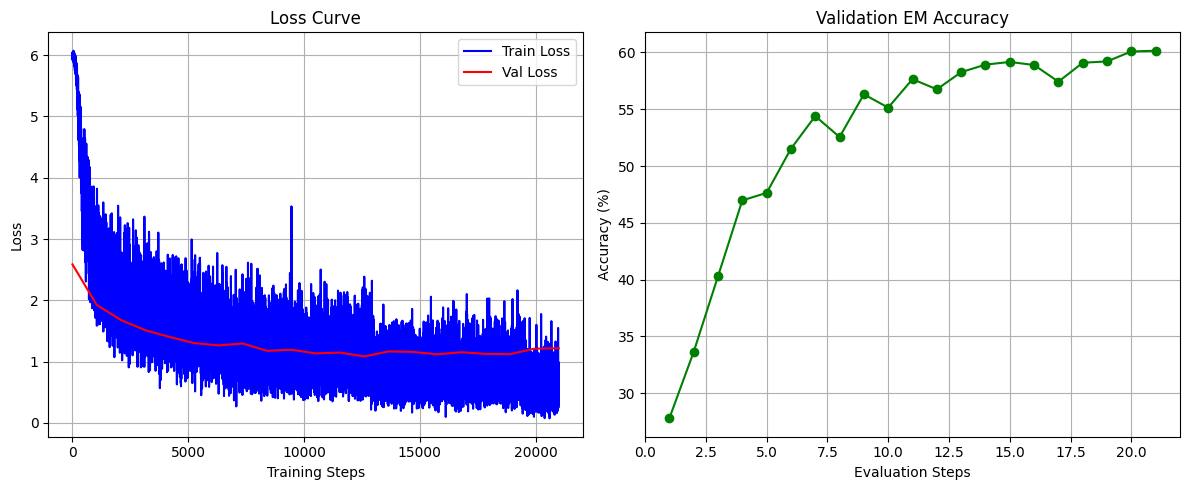

In [ ]:
# ============================================================
# PLOT TRAINING LOSS, VALIDATION LOSS, AND VALIDATION ACCURACY
# ============================================================

# Step 1: Call the plotting function
# It expects lists of train_losses, val_losses, and val_accuracies as inputs
plot_loss(train_losses, val_losses, val_accuracies)



# **Save Fine-Tuned BERT QA Model and Tokenizer **
Option1

This section saves a fine-tuned BERT Question Answering model and its tokenizer to a local directory (/content/qa_model_checkpoint) so that it can be reloaded later for inference, evaluation, or sharing.

In [ ]:
# saving fine-tuned BERT QA model and tokenizer to a local directory on disk

import os
from transformers import BertForQuestionAnswering

#  Set folder path to save locally
model_dir = "/content/qa_model_checkpoint"
os.makedirs(model_dir, exist_ok=True)

# Save model
model.save_pretrained(model_dir)

#  Save tokenizer
tokenizer.save_pretrained(model_dir)

print(f" Model and tokenizer saved to: {model_dir}")


 Model and tokenizer saved to: /content/qa_model_checkpoint


Backup Fine-Tuned BERT QA Model to Google Drive

Option 2

This section saves your trained BERT QA model and tokenizer to local disk, then copies them to your Google Drive for safe backup. This ensures the model is preserved across Colab sessions.




In [ ]:
#  backing up fine-tuned model and tokenizer to Google Drive, making it easy to preserve and access your trained model later.


import os
from transformers import BertForQuestionAnswering

# Define the directory path where model and tokenizer will be saved
model_dir = "/content/drive/My Drive/SQuAD_QA_Mode-V8"

# Create the directory if it doesn't already exist
os.makedirs(model_dir, exist_ok=True)

# Save the fine-tuned BERT model to the specified directory
# This includes the model's configuration and learned weights
model.save_pretrained(model_dir)

# Save the tokenizer that was used to prepare the training data
# This includes vocab files and tokenizer configuration
tokenizer.save_pretrained(model_dir)

# Print the path to confirm where the model and tokenizer were saved
print(f"Model and tokenizer saved to: {model_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer copied to Google Drive at: /content/drive/My Drive/SQuAD_QA_Mode-V4-sk


# Load Fine-Tuned BERT QA Model for Inference

Option-1

This section loads a previously saved BERT Question Answering model and tokenizer from local or Drive storage. This is required for making predictions on new questions using the fine-tuned model.


In [ ]:
# loading fine-tuned BERT QA model for inference

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# Path to your fine-tuned model
model_path = "./qa_model_checkpoint"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_path)
model.eval()


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

Load Fine-Tuned BERT QA Model from Google Drive

Option 2

This section loads a fine-tuned BERT QA model and its tokenizer from a specified Google Drive folder, then maps the model to GPU (if available) for inference.


In [ ]:
from transformers import AutoTokenizer, BertForQuestionAnswering
import torch

# Use raw string to handle space in the Google Drive path
model_path = r"/content/drive/My Drive/SQuAD_QA_Mode-V4-atk"

# Load tokenizer and model from local directory
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True, local_files_only=True) #add local_files_only
model = BertForQuestionAnswering.from_pretrained(model_path, local_files_only=True) #add local_files_only

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

#  Download Official SQuAD 2.0 Validation Set
This command downloads the official dev-v2.0.json file from the SQuAD dataset repository and saves it locally as squad2_validation.json for use in evaluation

In [ ]:
# =============================================
# DOWNLOAD SQuAD v2.0 VALIDATION DATASET FILE
# =============================================

# This will download the official development/validation file for SQuAD 2.0
# and save it as 'squad2_validation.json' in the current working directory

!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad2_validation.json



--2025-04-26 10:18:02--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad2_validation.json’

squad2_validation.j 100%[===================>]   4.17M  --.-KB/s    in 0.01s   

2025-04-26 10:18:03 (291 MB/s) - ‘squad2_validation.json’ saved [4370528/4370528]



**Load and Inspect SQuAD v2.0 Validation Dataset from JSON**

This section loads the official SQuAD 2.0 validation dataset from a local JSON file, extracts the core "data" structure, and prints the number of articles for verification.

In [ ]:
# loading and inspecting the SQuAD v2.0 validation dataset from a local JSON file.

import json

# Load SQuAD v2.0 validation dataset
with open("squad2_validation.json", "r") as f:
    squad_data = json.load(f)["data"]  # Extract only the "data" section

# Sanity check: print number of articles
print("Number of articles loaded:", len(squad_data))
squad_data[0].keys()

Number of articles loaded: 35


dict_keys(['title', 'paragraphs'])

# **Run Inference on SQuAD v2.0 Validation Set Using Fine-Tuned BERT QA Model**

This section runs inference on the SQuAD v2.0 validation dataset using a fine-tuned BERT QA model. It computes answer spans and no-answer probabilities for each question and saves results to two dictionaries: predictions and na_probs.

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F  # For sigmoid function

# ================================================
# SETUP: Move model to appropriate device (GPU/CPU)
# ================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure model runs on GPU if available


# =========================================
# INITIALIZE STORAGE FOR PREDICTIONS
# =========================================

predictions = {}  # Store final answers keyed by question ID
na_probs = {}     # Store no-answer probabilities by question ID


# =========================================
# LOOP THROUGH EACH ARTICLE, PARAGRAPH, AND QUESTION
# =========================================

for article in tqdm(squad_data, desc="Processing Articles"):
    for paragraph in article["paragraphs"]:
        context = paragraph["context"]

        for qa in paragraph["qas"]:
            question = qa["question"]
            qid = qa["id"]  # Unique question ID

            # Tokenize the question-context pair
            inputs = tokenizer(
                question,
                context,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(device)  # Ensure inputs are also on the correct device

            # Run inference without computing gradients
            with torch.no_grad():
                outputs = model(**inputs)

            # Extract logits and input token IDs
            input_ids = inputs["input_ids"][0]
            start_logits = outputs.start_logits[0]
            end_logits = outputs.end_logits[0]

            # Limit maximum answer span
            max_answer_length = 30

            # Initialize variables to track best span
            best_score = float("-inf")
            best_start = best_end = 0

            # Brute-force search for best start-end span pair
            for i in range(len(start_logits)):
                for j in range(i, min(i + max_answer_length, len(end_logits))):
                    score = start_logits[i] + end_logits[j]
                    if score > best_score:
                        best_start = i
                        best_end = j
                        best_score = score

            # Decode best span to text
            predicted_tokens = input_ids[best_start:best_end + 1]
            answer_text = tokenizer.decode(predicted_tokens, skip_special_tokens=True).strip()

            # Compute null (no-answer) score using [CLS] token logit
            null_score = (start_logits[0] + end_logits[0]).item()

            # Calculate difference between null score and best span score
            logit_diff = null_score - best_score

            # Convert difference to probability using sigmoid
            na_prob = F.sigmoid(torch.tensor(logit_diff)).item()

            # Apply threshold to decide whether to return an empty answer
            threshold = 0.25
            predictions[qid] = "" if na_prob > threshold else answer_text
            na_probs[qid] = round(na_prob, 4)



Processing Articles:   0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-21-df33a0cdafcb>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  na_prob = F.sigmoid(torch.tensor(logit_diff)).item()
Processing Articles: 100%|██████████| 35/35 [46:24<00:00, 79.55s/it]


# **Save and Download Model Predictions for Evaluation**
This step writes both dictionaries (predictions, na_probs) into properly formatted .json files.



In [ ]:
# ========================================================
# SAVE AND DOWNLOAD MODEL OUTPUTS FOR OFFLINE EVALUATION
# ========================================================

from google.colab import files
import json  # Ensure json is imported before saving

# Step 1: Save predictions dictionary to a JSON file
# Each key is a question ID; value is the predicted answer text
with open("predictions.json", "w") as f:
    json.dump(predictions, f)

# Step 2: Save no-answer probabilities to a separate JSON file
# Each key is a question ID; value is a float indicating the probability
with open("na_prob.json", "w") as f:
    json.dump(na_probs, f)

# Step 3: Use Colab's file download API to trigger downloads
files.download("predictions.json")
files.download("na_prob.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save Model Predictions to Google Drive**

This section saves the model's predictions and no-answer probabilities to a specified folder in your Google Drive. Run this block after your prediction loop finishes to persist outputs between Colab sessions

In [ ]:
# =======================================================
# SAVE MODEL PREDICTIONS AND NO-ANSWER PROBABILITIES TO GOOGLE DRIVE
# =======================================================

import os
import json
from google.colab import drive

# Step 1: Mount Google Drive (if not already mounted)
# Prompts you to authorize access via your Google account
drive.mount('/content/drive')

# Step 2: Define output folder path in Drive and create if it doesn't exist
output_folder = "/content/drive/MyDrive/QA_Evaluation_Files_V4/"
os.makedirs(output_folder, exist_ok=True)

# Step 3: Save predictions dictionary to predictions.json
with open(os.path.join(output_folder, "predictions.json"), "w") as f:
    json.dump(predictions, f)

# Step 4: Save no-answer probabilities to na_prob.json
with open(os.path.join(output_folder, "na_prob.json"), "w") as f:
    json.dump(na_probs, f)

# Step 5: Confirm successful save
print("Files saved to your Google Drive folder at:\n", output_folder)



**Load Saved Predictions and No-Answer Probabilities from Google Drive**

his block mounts Google Drive (if not already mounted) and loads previously saved predictions.json and na_prob.json files from the specified directory into Python dictionaries, ready for evaluation.

In [ ]:
# ============================================================
# LOAD SAVED MODEL PREDICTIONS AND NO-ANSWER PROBABILITIES FROM GOOGLE DRIVE
# ============================================================

import os
import json
from google.colab import drive

# Step 1: Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Step 2: Define the same output folder path used during saving
input_folder = "/content/drive/MyDrive/QA_Evaluation_Files_V4/"

# Step 3: Load predictions from predictions.json
predictions_path = os.path.join(input_folder, "predictions.json")
if os.path.exists(predictions_path):
    with open(predictions_path, "r") as f:
        predictions = json.load(f)
    print("Predictions loaded successfully.")
else:
    raise FileNotFoundError(f"predictions.json not found in {input_folder}")

# Step 4: Load no-answer probabilities from na_prob.json
na_prob_path = os.path.join(input_folder, "na_prob.json")
if os.path.exists(na_prob_path):
    with open(na_prob_path, "r") as f:
        na_probs = json.load(f)
    print("No-answer probabilities loaded successfully.")
else:
    raise FileNotFoundError(f"na_prob.json not found in {input_folder}")


# **Download Official SQuAD v2.0 Evaluation Script**


This command downloads the evaluate-v2.0.py script from the official SQuAD GitHub repository. The script is used to evaluate model predictions against the ground-truth answers using Exact Match (EM) and F1 Score, with special support for unanswerable questions (SQuAD 2.0).



In [ ]:
!wget https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/master/evaluate-v2.0.py -O squad_evaluate.py


--2025-04-26 11:05:39--  https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/master/evaluate-v2.0.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10547 (10K) [text/plain]
Saving to: ‘squad_evaluate.py’

squad_evaluate.py   100%[===================>]  10.30K  --.-KB/s    in 0s      

2025-04-26 11:05:40 (117 MB/s) - ‘squad_evaluate.py’ saved [10547/10547]



** Run Official SQuAD v2.0 Evaluation with No-Answer Threshold**

This command executes the official squad_evaluate.py script to evaluate your model’s predictions on the SQuAD 2.0 validation set. It calculates metrics like Exact Match (EM), F1 Score, and includes support for no-answer evaluation using na_prob.json. The -t flag sets the no-answer threshold (e.g., 0.5).



In [ ]:
# =========================================================
# RUN OFFICIAL EVALUATION SCRIPT FOR SQuAD V2.0 PREDICTIONS
# =========================================================

# Arguments:
# squad2_validation.json  - The original validation dataset (ground truth)
# predictions.json        - Your model's predicted answers
# -n na_prob.json         - Model's predicted no-answer probabilities
# -o eval_output.json     - Where to save evaluation results
# -t 0.5                  - Threshold: if na_prob > 0.5, treat as unanswerable

!python3 squad_evaluate.py \
    squad2_validation.json \
    predictions.json \
    -n na_prob.json \
    -o eval_output.json \
    -t 0.5


**Verify and Display Evaluation Results from Output File **

This block checks whether the evaluation results file (eval_output.json) was successfully created after running the evaluation script. If found, it loads the file and prints each metric like Exact Match, F1, and others.

In [ ]:
# =====================================================
# CHECK AND DISPLAY SQuAD V2.0 EVALUATION RESULTS
# =====================================================

import os
import json

# Step 1: Check if evaluation output file exists
if os.path.exists("eval_output.json"):
    # Step 2: If file exists, load the JSON content
    with open("eval_output.json", "r") as f:
        results = json.load(f)

    # Step 3: Print evaluation metrics nicely
    print("Evaluation Results:")
    for key, value in results.items():
        print(f"{key}: {value:.2f}")
else:
    # Step 4: If file was not created, notify the user
    print("eval_output.json was not created. Something went wrong.")


Evaluation Results:
exact: 47.28
f1: 52.99
total: 11873.00
HasAns_exact: 60.04
HasAns_f1: 71.47
HasAns_total: 5928.00
NoAns_exact: 34.57
NoAns_f1: 34.57
NoAns_total: 5945.00
best_exact: 58.52
best_exact_thresh: 0.00
best_f1: 62.60
best_f1_thresh: 0.00


# **Full Evaluation Pipeline for SQuAD v2.0 Predictions**

This unified block loads the original SQuAD 2.0 validation dataset, your model predictions, and no-answer probabilities. It defines all helper functions to normalize answers, compute Exact Match (EM) and F1 scores, apply no-answer thresholds, and print final evaluation results.



In [ ]:
# ============================================================
# FULL EVALUATION: SQuAD V2.0 MODEL PREDICTIONS (WITH THRESHOLD)
# ============================================================

import json
import re
import string
import numpy as np
import collections
import matplotlib.pyplot as plt
import os

# Step 1: Load original SQuAD 2.0 validation dataset
with open("squad2_validation.json", "r") as f:
    dataset = json.load(f)["data"]  # Only extract the "data" section

# Step 2: Load model predictions (qid → predicted answer text)
with open("predictions.json", "r") as f:
    preds = json.load(f)

# Step 3: Load no-answer probabilities (qid → float)
with open("na_prob.json", "r") as f:
    na_probs = json.load(f)

# -------------------------------------------
# Normalization Helpers for Answer Comparison
# -------------------------------------------

def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

# -------------------------------------------
# Exact Match and F1 Score Calculation
# -------------------------------------------

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = num_same / len(pred_toks)
    recall = num_same / len(gold_toks)
    return (2 * precision * recall) / (precision + recall)

# -------------------------------------------
# Map QIDs to "has answer" flags from GT data
# -------------------------------------------

def make_qid_to_has_ans(dataset):
    qid_to_has_ans = {}
    for article in dataset:
        for p in article["paragraphs"]:
            for qa in p["qas"]:
                qid = qa["id"]
                qid_to_has_ans[qid] = bool(qa["answers"])
    return qid_to_has_ans

# -------------------------------------------
# Score All QAs Against Ground Truth (Raw Scores)
# -------------------------------------------

def get_raw_scores(dataset, preds):
    exact_scores = {}
    f1_scores = {}

    for article in dataset:
        for p in article["paragraphs"]:
            for qa in p["qas"]:
                qid = qa["id"]
                gold_answers = [a["text"] for a in qa["answers"] if a["text"].strip()]
                if not gold_answers:
                    gold_answers = [""]  # For unanswerable questions

                if qid not in preds:
                    continue  # Skip if prediction is missing

                pred = preds[qid]
                exact = max(compute_exact(a, pred) for a in gold_answers)
                f1 = max(compute_f1(a, pred) for a in gold_answers)

                exact_scores[qid] = exact
                f1_scores[qid] = f1

    return exact_scores, f1_scores

# -------------------------------------------
# Override Scores Based on No-Answer Threshold
# -------------------------------------------

def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans, threshold):
    new_scores = {}
    for qid, score in scores.items():
        is_pred_na = na_probs.get(qid, 0.0) > threshold
        if is_pred_na:
            # Give score 1.0 if question truly has no answer
            new_scores[qid] = float(not qid_to_has_ans[qid])
        else:
            new_scores[qid] = score
    return new_scores

# -------------------------------------------
# Compute Overall Evaluation Metrics
# -------------------------------------------

def make_eval_dict(exact_scores, f1_scores, qid_to_has_ans, threshold):
    has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
    no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]

    exact_thresh = apply_no_ans_threshold(exact_scores, na_probs, qid_to_has_ans, threshold)
    f1_thresh = apply_no_ans_threshold(f1_scores, na_probs, qid_to_has_ans, threshold)

    def average(scores, qids):
        return 100.0 * sum(scores[qid] for qid in qids) / len(qids) if qids else 0.0

    results = {
        "exact": average(exact_thresh, exact_thresh.keys()),
        "f1": average(f1_thresh, f1_thresh.keys()),
        "HasAns_exact": average(exact_thresh, has_ans_qids),
        "HasAns_f1": average(f1_thresh, has_ans_qids),
        "NoAns_exact": average(exact_thresh, no_ans_qids),
        "NoAns_f1": average(f1_thresh, no_ans_qids),
    }
    return results

# -------------------------------------------
# Run Evaluation and Print Results
# -------------------------------------------

threshold = 0.0  # Adjust this threshold as needed
qid_to_has_ans = make_qid_to_has_ans(dataset)
exact_raw, f1_raw = get_raw_scores(dataset, preds)
eval_results = make_eval_dict(exact_raw, f1_raw, qid_to_has_ans, threshold=threshold)

print("Evaluation Results @ threshold:", threshold)
for k, v in eval_results.items():
    print(f"{k}: {v:.2f}")


Evaluation Results @ threshold: 0.0
exact: 58.52
f1: 62.48
HasAns_exact: 47.13
HasAns_f1: 55.07
NoAns_exact: 69.87
NoAns_f1: 69.87


In [ ]:
# Prepare mappings



✅ Evaluation Results @ threshold : 0.25
exact: 58.52
f1: 62.48
HasAns_exact: 47.13
HasAns_f1: 55.07
NoAns_exact: 69.87
NoAns_f1: 69.87


# **Threshold Sweep for Best F1 and EM Scores**

This block systematically sweeps across different no-answer probability thresholds (from 0 to 1) to find the threshold that maximizes Exact Match (EM) and F1 scores. It also plots the results to help visualize how thresholding impacts model performance.

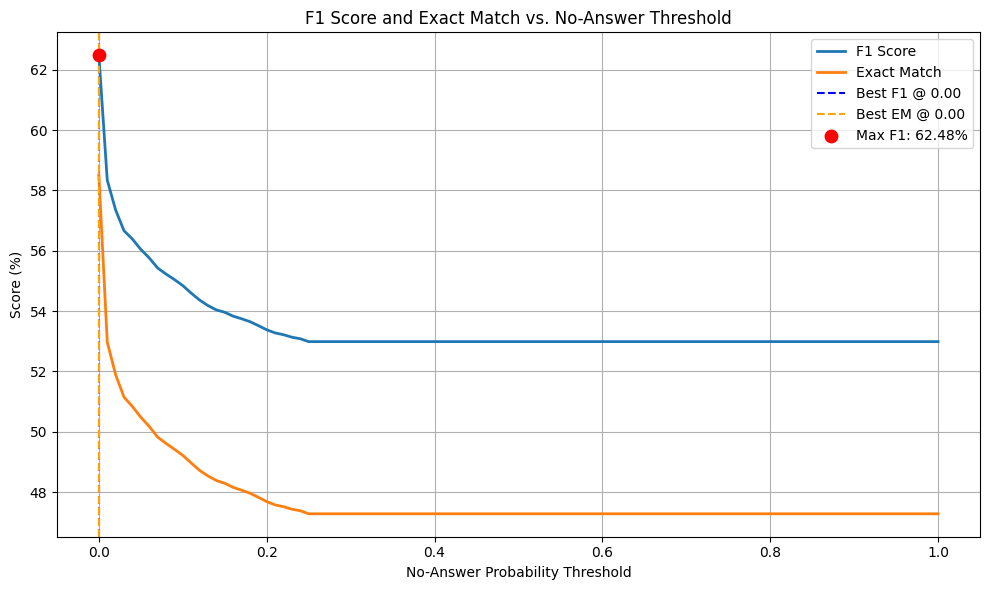

Best F1 Score: 62.48% at threshold 0.00
Best EM Score: 58.52% at threshold 0.00


In [ ]:
# =========================================================
# THRESHOLD SWEEP: OPTIMIZE F1 AND EXACT MATCH (SQuAD V2.0)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define range of thresholds to test
# Sweep thresholds from 0.00 to 1.00 in 0.01 steps
thresholds = np.linspace(0, 1, 101)

# Step 2: Initialize lists to store F1 and EM scores at each threshold
f1_scores = []
em_scores = []

# Step 3: Evaluate model at each threshold
for t in thresholds:
    result = make_eval_dict(exact_raw, f1_raw, qid_to_has_ans, threshold=t)
    f1_scores.append(result["f1"])
    em_scores.append(result["exact"])

# Step 4: Identify the threshold that gives the best F1 and best EM
best_f1 = max(zip(thresholds, f1_scores), key=lambda x: x[1])
best_em = max(zip(thresholds, em_scores), key=lambda x: x[1])

# Step 5: Plot F1 and EM scores against thresholds
# ========================================================
# PLOT F1 & EM SCORES vs THRESHOLD, WITH BEST F1 HIGHLIGHT
# ========================================================

plt.figure(figsize=(10, 6))

# Plot F1 and Exact Match curves
plt.plot(thresholds, f1_scores, label="F1 Score", linewidth=2)
plt.plot(thresholds, em_scores, label="Exact Match", linewidth=2)

# Mark vertical lines at best F1 and best EM
plt.axvline(best_f1[0], linestyle="--", color="blue", label=f"Best F1 @ {best_f1[0]:.2f}", linewidth=1.5)
plt.axvline(best_em[0], linestyle="--", color="orange", label=f"Best EM @ {best_em[0]:.2f}", linewidth=1.5)

# Add a red dot exactly at the best F1 point
plt.scatter(best_f1[0], best_f1[1], color='red', s=80, zorder=5, label=f"Max F1: {best_f1[1]:.2f}%")

# General plot settings
plt.title("F1 Score and Exact Match vs. No-Answer Threshold")
plt.xlabel("No-Answer Probability Threshold")
plt.ylabel("Score (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Print the best F1 and EM scores with corresponding thresholds
print(f"Best F1 Score: {best_f1[1]:.2f}% at threshold {best_f1[0]:.2f}")
print(f"Best EM Score: {best_em[1]:.2f}% at threshold {best_em[0]:.2f}")


**Automatically Apply the Best F1 Threshold**

In [ ]:
# ===============================================================
# APPLY BEST F1 THRESHOLD AND RE-EVALUATE FINAL MODEL PERFORMANCE
# ===============================================================

# Step 1: Extract the threshold that gave best F1
optimal_threshold = best_f1[0]

# Step 2: Re-run evaluation at the optimal threshold
final_eval_results = make_eval_dict(exact_raw, f1_raw, qid_to_has_ans, threshold=optimal_threshold)

# Step 3: Display updated evaluation results
print("\nFinal Evaluation using Best F1 Threshold:")
print(f"Optimal No-Answer Threshold: {optimal_threshold:.2f}")

for metric, value in final_eval_results.items():
    print(f"{metric}: {value:.2f}")



Final Evaluation using Best F1 Threshold:
Optimal No-Answer Threshold: 0.00
exact: 58.52
f1: 62.48
HasAns_exact: 47.13
HasAns_f1: 55.07
NoAns_exact: 69.87
NoAns_f1: 69.87


# **Randomly Inspect Answerable Questions and Model Predict**

This block iterates through the SQuAD 2.0 validation dataset, collects a subset of answerable questions, compares ground truth answers with model predictions, and displays a few random examples for easy inspection.



In [ ]:
# iterates over the SQuAD validation dataset and finds questions that have ground truth answers.

import random
from IPython.display import display, Markdown

# Collect a few answerable QIDs
answerable_samples = []

for article in dataset:
    for p in article["paragraphs"]:
        context = p["context"]
        for qa in p["qas"]:
            if qa["answers"]:
                qid = qa["id"]
                if qid in preds:
                    answer = qa["answers"][0]["text"]
                    question = qa["question"]
                    pred = preds[qid]
                    na_prob = na_probs.get(qid, 0.0)

                    answerable_samples.append({
                        "id": qid,
                        "question": question,
                        "context": context,
                        "answer": answer,
                        "prediction": pred,
                        "na_prob": na_prob
                    })

# Show 5 random samples
sampled = random.sample(answerable_samples, 5)

for ex in sampled:
    display(Markdown(f"""
###  Question ID: `{ex['id']}`
** Question**: {ex['question']}

** Ground Truth Answer**: `{ex['answer']}`
** Model Prediction**: `{ex['prediction']}`
** No-Answer Prob**: `{ex['na_prob']}`

** Context Snippet**:
`...{ex['context'][0:400]}...`
"""))



###  Question ID: `56e1e9dfe3433e14004231fc`
** Question**: What is the problem attributed to defining if two finite graphs are isomorphic?

** Ground Truth Answer**: `The graph isomorphism problem`
** Model Prediction**: `the graph isomorphism problem`
** No-Answer Prob**: `0.0047`

** Context Snippet**:
`...The graph isomorphism problem is the computational problem of determining whether two finite graphs are isomorphic. An important unsolved problem in complexity theory is whether the graph isomorphism problem is in P, NP-complete, or NP-intermediate. The answer is not known, but it is believed that the problem is at least not NP-complete. If graph isomorphism is NP-complete, the polynomial time hie...`



###  Question ID: `57283f014b864d19001647e8`
** Question**: What society founded the University of Chicago?

** Ground Truth Answer**: `the American Baptist Education Society`
** Model Prediction**: `american baptist education society`
** No-Answer Prob**: `0.1556`

** Context Snippet**:
`...Founded by the American Baptist Education Society with a donation from oil magnate and wealthiest man in history John D. Rockefeller, the University of Chicago was incorporated in 1890; William Rainey Harper became the university's first president in 1891, and the first classes were held in 1892. Both Harper and future president Robert Maynard Hutchins advocated for Chicago's curriculum to be base...`



###  Question ID: `57114667a58dae1900cd6d83`
** Question**: Who developed a successful steam engine indicator for Charles Porter?

** Ground Truth Answer**: `Charles Richard`
** Model Prediction**: `charles richard`
** No-Answer Prob**: `0.0`

** Context Snippet**:
`...The most useful instrument for analyzing the performance of steam engines is the steam engine indicator. Early versions were in use by 1851, but the most successful indicator was developed for the high speed engine inventor and manufacturer Charles Porter by Charles Richard and exhibited at London Exhibition in 1862. The steam engine indicator traces on paper the pressure in the cylinder throughou...`



###  Question ID: `57263677ec44d21400f3dc4a`
** Question**: What was report P-2626

** Ground Truth Answer**: `a general architecture for a large-scale, distributed, survivable communications network`
** Model Prediction**: `report rm 3420 in 1964`
** No-Answer Prob**: `0.0002`

** Context Snippet**:
`...Baran developed the concept of distributed adaptive message block switching during his research at the RAND Corporation for the US Air Force into survivable communications networks, first presented to the Air Force in the summer of 1961 as briefing B-265, later published as RAND report P-2626 in 1962, and finally in report RM 3420 in 1964. Report P-2626 described a general architecture for a large...`



###  Question ID: `57293c246aef051400154bb8`
** Question**: Who is on the IPCC Panel?

** Ground Truth Answer**: `representatives appointed by governments and organizations`
** Model Prediction**: `representatives appointed by governments and organizations`
** No-Answer Prob**: `0.0`

** Context Snippet**:
`...The IPCC Panel is composed of representatives appointed by governments and organizations. Participation of delegates with appropriate expertise is encouraged. Plenary sessions of the IPCC and IPCC Working groups are held at the level of government representatives. Non Governmental and Intergovernmental Organizations may be allowed to attend as observers. Sessions of the IPCC Bureau, workshops, exp...`


# **Predict Answer from Context Using Fine-Tuned BERT QA Model**

This function predicts an answer from a given question and context using a fine-tuned BERT model. It robustly handles no-answer cases using a no-answer probability threshold and careful span selection with offset mapping.


In [ ]:
# =============================================================
# FUNCTION: Predict Answer from Context Using Fine-Tuned BERT
# =============================================================

import torch
import torch.nn.functional as F  # For sigmoid function

def predict_answer_v2(question, context, model, tokenizer, max_length=384, threshold=0.5, max_span_length=30):
    """
    Predicts an answer span from a given context using a fine-tuned BERT QA model.

    Parameters:
        question (str): Input question string.
        context (str): Input context string.
        model (torch.nn.Module): Fine-tuned BERT model for QA.
        tokenizer (transformers tokenizer): Tokenizer used with the model.
        max_length (int): Maximum tokenized input length.
        threshold (float): No-answer probability threshold.
        max_span_length (int): Maximum token span to consider valid.

    Returns:
        dict: Dictionary containing 'answer', 'na_probability', and 'confidence_score'.
    """

    # Step 1: Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Step 2: Tokenize inputs with offset mapping for character-level span recovery
        inputs = tokenizer(
            question,
            context,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            return_offsets_mapping=True,
            padding="max_length"
        )

        # Extract offset mapping separately (not passed to model)
        offset_mapping = inputs.pop("offset_mapping")[0]

        # Move all tensor inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Step 3: Forward pass through the model
        outputs = model(**inputs)
        start_logits = outputs.start_logits[0]
        end_logits = outputs.end_logits[0]
        input_ids = inputs["input_ids"][0]

        # Step 4: Find the best span based on start and end logits
        best_score = float("-inf")
        best_start = best_end = 0

        for i in range(len(start_logits)):
            for j in range(i, min(i + max_span_length, len(end_logits))):
                score = start_logits[i] + end_logits[j]
                if score > best_score:
                    best_start = i
                    best_end = j
                    best_score = score

        # Step 5: Decode the predicted span using character offsets
        start_char = offset_mapping[best_start][0].item()
        end_char = offset_mapping[best_end][1].item()
        predicted_answer = context[start_char:end_char].strip()

        # Step 6: Compute no-answer probability from logits
        null_score = (start_logits[0] + end_logits[0]).item()
        logit_diff = null_score - best_score
        na_prob = F.sigmoid(torch.tensor(logit_diff)).item()

        # Step 7: Final decision based on threshold and span validity
        if na_prob > threshold or end_char <= start_char:
            return {
                "answer": "No answer",
                "na_probability": round(na_prob, 4),
                "confidence_score": round(best_score.item() if isinstance(best_score, torch.Tensor) else best_score, 4)
            }
        else:
            return {
                "answer": predicted_answer,
                "na_probability": round(na_prob, 4),
                "confidence_score": round(best_score.item() if isinstance(best_score, torch.Tensor) else best_score, 4)
            }


**Test Fine-Tuned BERT QA Model on Custom Question-Context Pair**

This block demonstrates how to use the predict_answer_v2 function to infer an answer for a custom context and question using a fine-tuned BERT Question Answering model. It prints the predicted answer, the no-answer probability, and the span confidence score.


In [ ]:
# ===========================================================
# PREDICT ANSWER FROM A CUSTOM CONTEXT-QUESTION EXAMPLE
# ===========================================================

# Define a sample context paragraph
context = """
Black Slave's Cry to Heaven was a 1907 stage play performed by the Spring Willow Society, a Chinese student troupe, in Tokyo,
 Japan. Adapted by Zeng Xiaogu from a translation of Harriet Beecher Stowe's novel Uncle Tom's Cabin,
 the play focused on the experiences and eventual escape of two slaves, Eliza and George, after killing several of their pursuers.
 Modified to allegorically call attention to the experiences of Chinese migrants in the United States, Black Slave's Cry to Heaven was innovative in its use of spoken dialogue and realistic set designs. Performed twice at the Hongō-za Theatre, the show was well received by critics and audiences. Although its script has been lost, the play has inspired subsequent works. Due to its technical innovations and nationalist themes,
Black Slave's Cry to Heaven has been canonized as the first modern, Western-style Chinese drama.
"""

# Define a sample question related to the context
question = "What is Black Slave's Cry?"

# Step 1: Run inference using the predict_answer_v2 function
result = predict_answer_v2(question, context, model, tokenizer)

# Step 2: Display the prediction outputs
print("Answer:", result["answer"])
print("No-Answer Probability:", result["na_probability"])
print("Span Confidence Score:", result["confidence_score"])


Answer: first modern, Western-style Chinese drama
No-Answer Probability: 0.0099
Span Confidence Score: -2.0282


<ipython-input-32-980aa2f8b0de>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  na_prob = F.sigmoid(torch.tensor(logit_diff)).item()


# **Predict Answers and Evaluate Using Exact Match and Semantic Similarity **


In [ ]:
# ================================================================
# PREDICT ANSWERS AND EVALUATE WITH EXACT MATCH AND SEMANTIC SIMILARITY
# ================================================================

# Step 1: Install and import necessary libraries
!pip install -q sentence-transformers

import pandas as pd
import json
from tqdm import tqdm
from google.colab import files
from sentence_transformers import SentenceTransformer, util
from IPython.display import display, HTML

# Step 2: Load semantic similarity model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 3: Upload validation input file (JSON or CSV)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 4: Detect file type
if filename.endswith(".json"):
    input_type = "json"
elif filename.endswith(".csv"):
    input_type = "csv"
else:
    raise ValueError("Unsupported file type. Please upload a .json or .csv file.")

# Step 5: Initialize results storage
results = []

# Step 6: Process JSON input (SQuAD-like format)
if input_type == "json":
    with open(filename, "r") as f:
        squad_data = json.load(f)["data"]

    for article in tqdm(squad_data, desc="Processing JSON Articles"):
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                qid = qa["id"]
                question = qa["question"]
                true_answer = qa["answers"][0]["text"] if "answers" in qa and qa["answers"] else ""

                # Predict answer
                result = predict_answer_v2(question, context, model, tokenizer)

                # Compute semantic similarity
                sim_score = util.cos_sim(
                    semantic_model.encode(result["answer"], convert_to_tensor=True),
                    semantic_model.encode(true_answer, convert_to_tensor=True)
                ).item()

                # Determine match type
                if result["answer"].strip().lower() == true_answer.strip().lower():
                    match_type = "Exact"
                elif sim_score > 0.8:
                    match_type = "Semantic"
                else:
                    match_type = "Mismatch"

                results.append({
                    "QID": qid,
                    "Question": question,
                    "Ground Truth": true_answer,
                    "Prediction": result["answer"],
                    "No-Answer Probability": result["na_probability"],
                    "Confidence Score": result["confidence_score"],
                    "Semantic Similarity": round(sim_score, 4),
                    "Match Type": match_type
                })

    output_file = "semantic_predictions_json.csv"

# Step 7: Process CSV input (custom validation format)
elif input_type == "csv":
    df = pd.read_csv(filename)

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing CSV Rows"):
        question = row["question"]
        context = row["context"]
        true_answer = row.get("answer", "")

        # Predict answer
        result = predict_answer_v2(question, context, model, tokenizer)

        # Compute semantic similarity
        sim_score = util.cos_sim(
            semantic_model.encode(result["answer"], convert_to_tensor=True),
            semantic_model.encode(true_answer, convert_to_tensor=True)
        ).item()

        # Determine match type
        if result["answer"].strip().lower() == true_answer.strip().lower():
            match_type = "Exact"
        elif sim_score > 0.8:
            match_type = "Semantic"
        else:
            match_type = "Mismatch"

        results.append({
            "QID": row.get("id", idx),
            "Question": question,
            "Ground Truth": true_answer,
            "Prediction": result["answer"],
            "No-Answer Probability": result["na_probability"],
            "Confidence Score": result["confidence_score"],
            "Semantic Similarity": round(sim_score, 4),
            "Match Type": match_type
        })

    output_file = "semantic_predictions_csv.csv"

# Step 8: Save evaluation results to CSV
df_out = pd.DataFrame(results)
df_out.to_csv(output_file, index=False)

# Step 9: Download the output CSV
files.download(output_file)

# Step 10: Display first 20 rows for preview
print(f"Download Ready: {output_file}")
display(HTML(df_out.head(20).to_html(index=False)))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Saving French_Revolution.json to French_Revolution.json


Processing JSON Articles:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-32-980aa2f8b0de>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  na_prob = F.sigmoid(torch.tensor(logit_diff)).item()
Processing JSON Articles: 100%|██████████| 1/1 [00:12<00:00, 12.61s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download Ready: semantic_predictions_json.csv


QID,Question,Ground Truth,Prediction,No-Answer Probability,Confidence Score,Semantic Similarity,Match Type
French_Revolution_Revised_a_0,When did the French Revolution begin?,1789,1789,0.0000,14.5050,1.0000,Exact
French_Revolution_Revised_a_1,What event marked the symbolic beginning of the revolution?,The storming of the Bastille,The storming of the Bastille,0.0000,15.6251,1.0000,Exact
French_Revolution_Revised_a_2,Who was the king during the French Revolution?,King Louis XVI,Napoleon Bonaparte,0.0000,7.8414,0.4270,Mismatch
French_Revolution_Revised_a_3,Who led the Reign of Terror?,Robespierre,Robespierre,0.0000,13.2073,1.0000,Exact
French_Revolution_Revised_a_4,What happened to Queen Marie Antoinette?,She was executed,executed,0.0000,11.7024,0.7076,Mismatch
French_Revolution_Revised_a_5,What form of government replaced the monarchy?,The French Republic,absolute monarchy and the rise of the French Republic,0.0000,9.1413,0.7266,Mismatch
French_Revolution_Revised_a_6,What was the Reign of Terror?,A radical phase during which thousands were executed by guillotine,thousands were executed by guillotine under the leadership of Robespierre.,0.0001,2.1082,0.6980,Mismatch
French_Revolution_Revised_a_7,Who came to power after the revolution?,Napoleon Bonaparte,Napoleon Bonaparte,0.0000,10.5333,1.0000,Exact
French_Revolution_Revised_a_8,Why did the revolution start?,"Due to economic hardship, inequality, and desire for democracy","widespread economic hardship, social inequality, and a desire for more democratic governance",0.0000,14.9809,0.8672,Semantic
French_Revolution_Revised_a_9,What was used for mass executions during the revolution?,The guillotine,guillotine,0.0000,0.7381,0.9652,Semantic


# **Visualize and Analyze QA Model Performance Metrics**

This block generates visualizations and summary tables to analyze the fine-tuned QA model's performance based on exact matches, semantic similarity, no-answer probabilities, and confidence scores. It helps in understanding model behavior and spotting common errors.

<ipython-input-36-f0ce2033440c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_out, x="Match Type", palette="Set2")


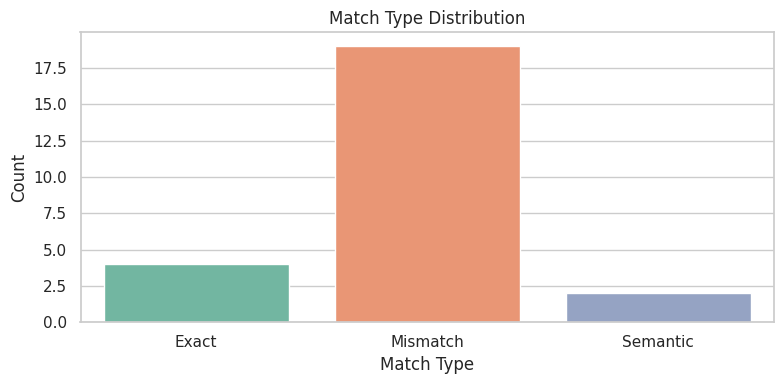

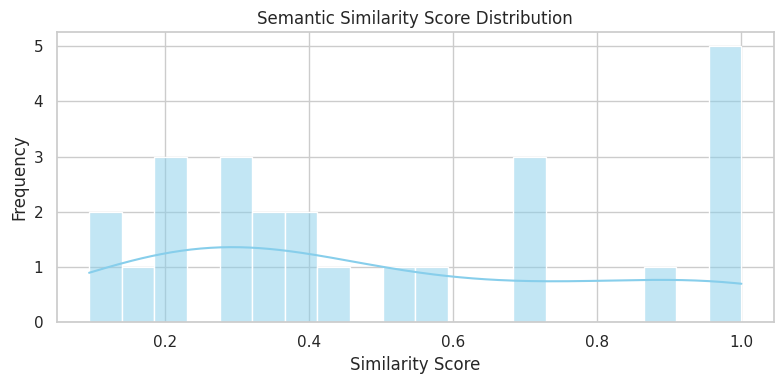

<ipython-input-36-f0ce2033440c>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_out, x="Match Type", y="No-Answer Probability", palette="pastel")


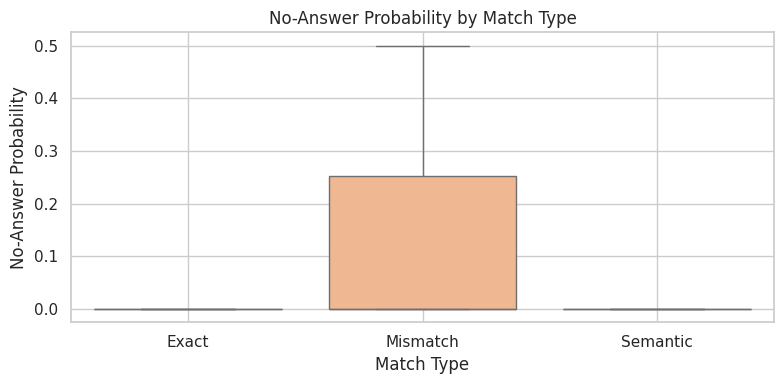

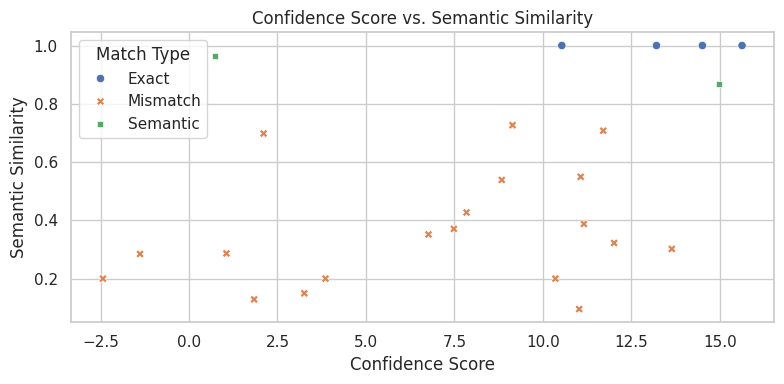

Match Type Summary Table:


Match Type,Count
Mismatch,19
Exact,4
Semantic,2


In [ ]:
# ============================================================
# VISUALIZATION: ANALYZE QA MODEL PERFORMANCE METRICS
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Step 1: Set plotting style and figure size globally
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

# ------------------------------------------------------------
# 1. Plot Match Type Distribution
# ------------------------------------------------------------
plt.figure()
sns.countplot(data=df_out, x="Match Type", palette="Set2")
plt.title("Match Type Distribution")
plt.ylabel("Count")
plt.xlabel("Match Type")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2. Plot Semantic Similarity Score Distribution
# ------------------------------------------------------------
plt.figure()
sns.histplot(df_out["Semantic Similarity"], bins=20, kde=True, color="skyblue")
plt.title("Semantic Similarity Score Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3. Plot No-Answer Probability by Match Type (Box Plot)
# ------------------------------------------------------------
plt.figure()
sns.boxplot(data=df_out, x="Match Type", y="No-Answer Probability", palette="pastel")
plt.title("No-Answer Probability by Match Type")
plt.xlabel("Match Type")
plt.ylabel("No-Answer Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Plot Confidence Score vs. Semantic Similarity (Scatter Plot)
# ------------------------------------------------------------
plt.figure()
sns.scatterplot(
    data=df_out,
    x="Confidence Score",
    y="Semantic Similarity",
    hue="Match Type",
    style="Match Type",
    palette="deep"
)
plt.title("Confidence Score vs. Semantic Similarity")
plt.xlabel("Confidence Score")
plt.ylabel("Semantic Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5. Show Full Match Type Summary Table
# ------------------------------------------------------------
summary = df_out["Match Type"].value_counts().reset_index()
summary.columns = ["Match Type", "Count"]

print("Match Type Summary Table:")
display(HTML(summary.to_html(index=False)))


# **Generate Confusion Matrix and Classification Report for QA Model**

This block generates a confusion matrix and a classification report for evaluating how accurately the QA model predicts whether a question is answerable or unanswerable, based on the ground truth and model predictions.

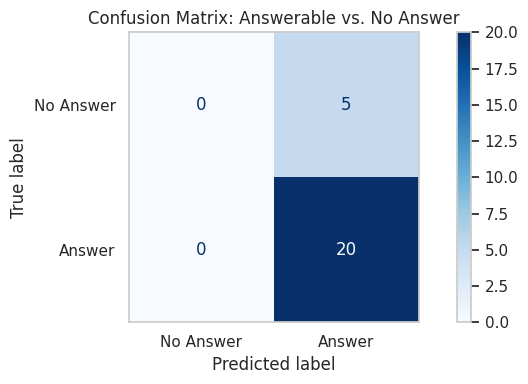

Classification Report (for Answerability Detection)

              precision    recall  f1-score   support

   No Answer       0.00      0.00      0.00         5
      Answer       0.80      1.00      0.89        20

    accuracy                           0.80        25
   macro avg       0.40      0.50      0.44        25
weighted avg       0.64      0.80      0.71        25



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ============================================================
# EVALUATE ANSWERABILITY PREDICTION USING CONFUSION MATRIX AND CLASSIFICATION REPORT
# ============================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# -----------------------
# STEP 1: Prepare True and Predicted Labels
# -----------------------

# True_Label: 1 if ground truth answer exists, else 0 (no answer)
df_out["True_Label"] = df_out["Ground Truth"].apply(lambda x: 0 if str(x).strip() == "" else 1)

# Pred_Label: 1 if model predicted an answer, else 0 (no answer predicted)
df_out["Pred_Label"] = df_out["Prediction"].apply(lambda x: 0 if str(x).strip() == "" else 1)

# -----------------------
# STEP 2: Generate Confusion Matrix
# -----------------------

# Compute confusion matrix
cm = confusion_matrix(df_out["True_Label"], df_out["Pred_Label"])

# Create a visual display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Answer", "Answer"])
disp.plot(cmap="Blues", values_format='d')

# Add title and remove grid
plt.title("Confusion Matrix: Answerable vs. No Answer")
plt.grid(False)
plt.tight_layout()
plt.show()

# -----------------------
# STEP 3: Generate Classification Report
# -----------------------

print("Classification Report (for Answerability Detection)\n")

# Print precision, recall, and f1-score for each class
print(classification_report(
    df_out["True_Label"],
    df_out["Pred_Label"],
    target_names=["No Answer", "Answer"]
))
